## PyTorch Built-in RNN Cell

In [2]:
import torch.nn as nn
import torch

In [3]:
# RNNCell(input_size: int, hidden_size: int, )

In [4]:
rnn = nn.RNNCell(3,5)
X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1
X_batch.size()#shape:(序列长度，batch_size,一个词用多少维度表示)

torch.Size([2, 4, 3])

In [5]:
# hx = rnn(X_batch[i], hx)
# hx

In [6]:
hx = torch.randn(4,5)#(batch_size,隐藏层神经单元个数)containing the initial hidden state for each element in the batch. 
                        #Defaults to zeros if not provided.
hx

tensor([[-2.0890, -0.4152, -0.7183,  0.3646, -0.5564],
        [ 0.9169, -2.2734,  0.7077,  0.4749,  1.8448],
        [-1.7083,  0.8465, -0.2968, -1.2104,  0.6500],
        [ 0.3053, -0.8704,  0.8881, -0.9396, -2.5413]])

In [7]:
### torch.RNNCell accepts a tensor as input and outputs the next hidden state 
### for each element in the batch.

In [9]:
output = []
# for each time step
for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)
    
print(output)
    

[tensor([[ 0.9779, -0.8711,  0.1046, -0.1574,  0.3489],
        [ 0.9130, -0.9754,  0.8464,  0.1709,  0.5305],
        [ 0.9788, -0.9918,  0.9804, -0.2442,  0.7184],
        [-0.8571,  0.5978,  0.9666, -0.7216,  0.6882]], grad_fn=<TanhBackward>), tensor([[ 0.8375, -0.9600,  0.9853, -0.4829,  0.8915],
        [ 0.9501, -0.6211, -0.2899, -0.3096,  0.4141],
        [ 0.9306, -0.8409,  0.8701, -0.6011,  0.8130],
        [ 0.3536, -0.3476,  0.5183, -0.5711,  0.5138]], grad_fn=<TanhBackward>)]


In [8]:
### 把上面写到一个class里

In [37]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()
        
        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons)  # initialize hidden state
        
    def forward(self, x):
        output = []
        
        # for each time step
        for i in range(2):
            self.hx = self.rnn(x[i], self.hx)
            output.append(self.hx)
            
        return output, self.hx

In [38]:
FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) # contains all output for all timesteps
print(states_val) # contains values for final state or final timestep, i.e., t=1

[tensor([[ 0.7314, -0.7800, -0.9684, -0.0577, -0.6491],
        [ 0.2841, -0.9924, -0.9986, -0.2111, -0.8811],
        [ 0.6939, -0.9998, -0.9994,  0.0742, -0.9397],
        [-0.9475, -0.9873, -0.9130,  0.9146,  0.9973]],
       grad_fn=<TanhBackward0>), tensor([[-0.2099, -1.0000, -0.9998,  0.9830, -0.7702],
        [-0.2741,  0.0602, -0.8088, -0.4135,  0.3130],
        [-0.4498, -0.9994, -0.9974,  0.9289, -0.1924],
        [-0.9604, -0.8459, -0.9258,  0.3996,  0.6573]],
       grad_fn=<TanhBackward0>)]
tensor([[-0.2099, -1.0000, -0.9998,  0.9830, -0.7702],
        [-0.2741,  0.0602, -0.8088, -0.4135,  0.3130],
        [-0.4498, -0.9994, -0.9974,  0.9289, -0.1924],
        [-0.9604, -0.8459, -0.9258,  0.3996,  0.6573]],
       grad_fn=<TanhBackward0>)


## RNN for Image Classification

In [39]:
#### 读取数据

In [40]:
import torchvision
#是pytorch中的图像预处理包，包含了很多种对图像数据进行变换的函数，
#这些都是在我们进行图像数据读入步骤中必不可少的。
import torchvision.transforms as transforms 

In [12]:
# train（bool，可选）–如果为True，则从training.pt创建数据集，否则从test.pt创建数据集。
#下载（bool，可选）–如果为true，则从internet下载数据集并将其放在根目录中。如果数据集已下载，则不会再次下载。
# transform（可调用，可选）–接受图像并返回图像的已转换版本。

In [42]:
BATCH_SIZE = 64

# list all transformations
#transforms.Compose(transforms) 方法是将多种变换组合在一起。
#transforms.ToTensor():将图像转换为tensor
transform = transforms.Compose(
        [transforms.ToTensor()])


# download and load train dataset
trainset = torchvision.datasets.MNIST(root='./data',train=True,
                                      download= True, transform = transform)

In [45]:
# trainset

In [46]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [47]:
# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [48]:
import matplotlib.pyplot as plt
import numpy as np

In [53]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

In [49]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [50]:
images.size()

torch.Size([64, 1, 28, 28])

In [19]:
images.size()#
# assert (torchvision.utils.make_grid(images)[0] == torchvision.utils.make_grid(images)[1]).all()

torch.Size([64, 1, 28, 28])

In [52]:
torchvision.utils.make_grid(images).size()

torch.Size([3, 242, 242])

#### And the output of the code is a batch of images displayed on a grid:

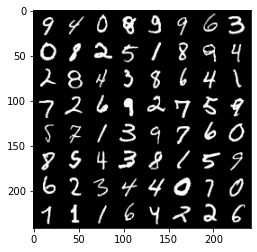

In [51]:
# show images
imshow(torchvision.utils.make_grid(images))

### Model

In [54]:
# parameters 
N_STEPS = 28#时间步数
N_INPUTS = 28#每个输入有多少位
N_NEURONS = 150#隐藏层的神经单元个数
N_OUTPUTS = 10#输出类别个数
N_EPHOCS = 10#训练10个epoch

<img src ="image/1.png" width = "700" height="500">

In [29]:
# help(nn.RNN)

In [55]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
    
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)我们使用num_layers=1，不用管这个参数
        return (torch.zeros(1,self.batch_size,self.n_neurons))
    
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1,0,2)
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        rnn_out, self.hidden = self.basic_rnn(X, self.hidden)
        #rnn_out：所有隐藏层的结果。
        #self.hidden：最后一层隐藏层的结果
#         print('*'*100,self.hidden.size())
#         print("###"*100,rnn_out.size())
        out = self.FC(self.hidden)
        
        return out.view(-1,self.n_outputs)## batch_size X n_output
    

### Testing the model with some samples

In [57]:
# images.size()

In [65]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1,28,28))
print(logits[0:2])#没有做softmax

tensor([[-0.0175,  0.0260,  0.0287, -0.0374, -0.0687, -0.0270,  0.0983,  0.0926,
         -0.0281,  0.1544],
        [-0.0264,  0.0391,  0.0103, -0.0473, -0.0690, -0.0439,  0.0831,  0.1003,
         -0.0114,  0.1393]], grad_fn=<SliceBackward0>)


In [66]:
torch.max(logits, 1)#返回概率和位置

torch.return_types.max(
values=tensor([0.1544, 0.1393, 0.1557, 0.1529, 0.1548, 0.1435, 0.1823, 0.1597, 0.1572,
        0.1563, 0.1513, 0.1542, 0.1547, 0.1546, 0.1379, 0.1552, 0.1376, 0.1477,
        0.1512, 0.1484, 0.1546, 0.1429, 0.1353, 0.1417, 0.1472, 0.1442, 0.1401,
        0.1562, 0.1449, 0.1551, 0.1369, 0.1635, 0.1390, 0.1476, 0.1514, 0.1387,
        0.1553, 0.1429, 0.1337, 0.1655, 0.1668, 0.1357, 0.1471, 0.1530, 0.1420,
        0.1544, 0.1430, 0.1651, 0.1551, 0.1372, 0.1540, 0.1488, 0.1568, 0.1494,
        0.1522, 0.1535, 0.1398, 0.1378, 0.1713, 0.1411, 0.1511, 0.1312, 0.1395,
        0.1489], grad_fn=<MaxBackward0>),
indices=tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]))

In [63]:
labels[0:10]

tensor([0, 8, 4, 5, 8, 1, 2, 3, 0, 7])

In [64]:
torch.max(logits, 1)#返回概率和位置

torch.return_types.max(
values=tensor([0.0725, 0.0713, 0.0776, 0.0789, 0.0762, 0.0770, 0.0690, 0.0781, 0.0770,
        0.0865, 0.0750, 0.0699, 0.1197, 0.0750, 0.1190, 0.0796, 0.1389, 0.0800,
        0.0746, 0.0683, 0.0874, 0.0863, 0.0768, 0.0766, 0.0637, 0.0758, 0.0713,
        0.0783, 0.1540, 0.0752, 0.0715, 0.0777, 0.0757, 0.0804, 0.0766, 0.0819,
        0.0718, 0.0783, 0.0814, 0.0702, 0.0726, 0.0783, 0.0755, 0.0738, 0.1188,
        0.0783, 0.1577, 0.0771, 0.0775, 0.1014, 0.0859, 0.0724, 0.0730, 0.0700,
        0.0763, 0.0775, 0.0779, 0.1022, 0.0802, 0.0739, 0.0854, 0.0781, 0.0680,
        0.0716], grad_fn=<MaxBackward0>),
indices=tensor([6, 5, 1, 6, 6, 6, 6, 6, 6, 6, 1, 5, 1, 1, 1, 6, 1, 1, 6, 5, 1, 6, 6, 1,
        1, 1, 6, 6, 1, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 7, 6, 1, 1, 1, 1,
        6, 1, 5, 6, 6, 6, 6, 5, 6, 1, 1, 6, 6, 6, 6, 1]))

In [67]:
labels

tensor([4, 8, 2, 4, 4, 0, 7, 3, 2, 1, 2, 3, 5, 2, 5, 2, 0, 8, 6, 4, 5, 1, 5, 3,
        4, 2, 3, 3, 0, 6, 3, 9, 0, 0, 5, 4, 2, 8, 8, 9, 9, 3, 8, 8, 9, 6, 0, 7,
        9, 9, 0, 4, 9, 1, 3, 6, 4, 3, 7, 4, 1, 8, 3, 5])

In [68]:
import torch.optim as optim

# Device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()#包含一个softmax操作和一个计算交叉熵的操作
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [69]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()#使用训练模式
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7902 | Train Accuracy: 74.26
Epoch:  1 | Loss: 0.3336 | Train Accuracy: 90.10
Epoch:  2 | Loss: 0.2446 | Train Accuracy: 93.00
Epoch:  3 | Loss: 0.1947 | Train Accuracy: 94.46
Epoch:  4 | Loss: 0.1665 | Train Accuracy: 95.25
Epoch:  5 | Loss: 0.1545 | Train Accuracy: 95.62
Epoch:  6 | Loss: 0.1475 | Train Accuracy: 95.84
Epoch:  7 | Loss: 0.1361 | Train Accuracy: 96.13
Epoch:  8 | Loss: 0.1232 | Train Accuracy: 96.53
Epoch:  9 | Loss: 0.1290 | Train Accuracy: 96.35


In [28]:
# next(model.parameters()).is_cuda